# RNN + GRU + bidirectional + Attentional context

This kernes uses a recurrent neural network in keras that uses GRU cells with a bidirectional layer and an attention context layer. The model uses the begining of the text and the end of the text and them join both outputs along with an one hot encoded layer for the gene and another for the variation. The variation has been encoded using the first and the last letter.

This kernel is based in a kernel by [ReiiNakanoBasic](https://www.kaggle.com/reiinakano/basic-nlp-bag-of-words-tf-idf-word2vec-lstm).

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

import gensim

import scikitplot.plotters as skplt

import nltk

import os

Using TensorFlow backend.


## Load data

In [2]:
df_train_txt = pd.read_csv('../input/training_text', sep='\|\|', header=None, skiprows=1, names=["ID","Text"])
df_train_var = pd.read_csv('../input/training_variants')
df_val_txt = pd.read_csv('../input/test_text', sep='\|\|', header=None, skiprows=1, names=["ID","Text"])
df_val_var = pd.read_csv('../input/test_variants')

df_test_txt = pd.read_csv('../input/stage2_test_text.csv', sep='\|\|', header=None, skiprows=1, names=["ID","Text"])
df_test_var = pd.read_csv('../input/stage2_test_variants.csv')

/home/jorge/companies/chute/pythonenv/iris3/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
/home/jorge/companies/chute/pythonenv/iris3/lib/python3.6/site-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jorge/companies/chute/pythonenv/iris3/lib/python3.6/site-packages/ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex se

In [3]:
df_val_txt = pd.read_csv('../input/test_text', sep='\|\|', header=None, skiprows=1, names=["ID","Text"])
df_val_var = pd.read_csv('../input/test_variants')
df_val_labels = pd.read_csv('../input/stage1_solution_filtered.csv')
df_val_labels['Class'] = pd.to_numeric(df_val_labels.drop('ID', axis=1).idxmax(axis=1).str[5:])
df_val_labels = df_val_labels[['ID', 'Class']]
df_val_txt = pd.merge(df_val_txt, df_val_labels, how='left', on='ID')

/home/jorge/companies/chute/pythonenv/iris3/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [4]:
df_train = pd.merge(df_train_var, df_train_txt, how='left', on='ID')
df_train.head()
df_test = pd.merge(df_test_var, df_test_txt, how='left', on='ID')
df_test.head()
df_val = pd.merge(df_val_var, df_val_txt, how='left', on='ID')
df_val = df_val[df_val_txt['Class'].notnull()]
df_val.head()

,ID,Gene,Variation,Text,Class
12,12,TET2,Y1902A,TET proteins oxidize 5-methylcytosine (5mC) on...,1.0
19,19,MTOR,D2512H,Genes encoding components of the PI3K-Akt-mTOR...,2.0
21,21,KIT,D52N,Myeloproliferative disorders (MPD) constitute ...,2.0
55,55,SPOP,F125V,"In the largest E3 ligase subfamily, Cul3 binds...",4.0
64,64,KEAP1,C23Y,Keap1 is the substrate recognition module of a...,4.0


## Word2Vec model

In [5]:
class MySentences(object):
    """MySentences is a generator to produce a list of tokenized sentences 
    
    Takes a list of numpy arrays containing documents.
    
    Args:
        arrays: List of arrays, where each element in the array contains a document.
    """
    def __init__(self, *arrays):
        self.arrays = arrays
 
    def __iter__(self):
        for array in self.arrays:
            for document in array:
                for sent in nltk.sent_tokenize(document):
                    yield nltk.word_tokenize(sent)

def get_word2vec(sentences, location):
    """Returns trained word2vec
    
    Args:
        sentences: iterator for sentences
        
        location (str): Path to save/load word2vec
    """
    if os.path.exists(location):
        print('Found {}'.format(location))
        model = gensim.models.Word2Vec.load(location)
        return model
    
    print('{} not found. training model'.format(location))
    model = gensim.models.Word2Vec(sentences, size=100, window=5, min_count=5, workers=8)
    print('Model done training. Saving to disk')
    model.save(location)
    return model

In [6]:
w2vec = get_word2vec(
    MySentences(
        df_train['Text'].values, 
        df_val['Text'].values
    ),
    'w2vmodel'
)

Found w2vmodel


### Tokenizer
We'll define a transformer (with sklearn interface) to convert a document into its corresponding vector

In [7]:
class MyTokenizer:
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        transformed_X = []
        for document in X:
            tokenized_doc = []
            for sent in nltk.sent_tokenize(document):
                tokenized_doc += nltk.word_tokenize(sent)
            transformed_X.append(np.array(tokenized_doc))
        return np.array(transformed_X)
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.wv.syn0[0])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = MyTokenizer().fit_transform(X)
        
        return np.array([
            np.mean([self.word2vec.wv[w] for w in words if w in self.word2vec.wv]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
    def fit_transform(self, X, y=None):
        return self.transform(X)


## RNN in Keras
We use a vocabulary of 10000 most used words and a sequence length of 3000 words (3000 for the beggining and 3000 for the ending)

This takes about few hours to run on GPU

In [6]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# Use the Keras tokenizer
VOCABULARY_SIZE = 10000
SEQUENCE_LENGTH = 3000
tokenizer = Tokenizer(num_words=VOCABULARY_SIZE)
tokenizer.fit_on_texts(df_train['Text'].values)

In [7]:
# Train set
train_set = df_train.sample(frac=1) # shuffle data first
train_set_input = tokenizer.texts_to_sequences(train_set['Text'].values)
train_set_input_reverse = [list(reversed(x)) for x in train_set_input]
train_set_input_begin = pad_sequences(train_set_input, maxlen=SEQUENCE_LENGTH)
train_set_input_end = pad_sequences(train_set_input_reverse, maxlen=SEQUENCE_LENGTH)
train_set_output = pd.get_dummies(train_set['Class']).values
print(train_set_input_begin.shape, train_set_input_end.shape, train_set_output.shape)

(3321, 3000) (3321, 3000) (3321, 9)


In [8]:
# Validation set
val_set_input = tokenizer.texts_to_sequences(df_val['Text'].values)
val_set_input_reverse = [list(reversed(x)) for x in val_set_input]
val_set_input_begin = pad_sequences(val_set_input, maxlen=SEQUENCE_LENGTH)
val_set_input_end = pad_sequences(val_set_input_reverse, maxlen=SEQUENCE_LENGTH)
val_set_output = pd.get_dummies(df_val['Class']).values
print(val_set_input_begin.shape, val_set_input_end.shape, val_set_output.shape)

(368, 3000) (368, 3000) (368, 9)


In [9]:
# Test set
test_set_input = tokenizer.texts_to_sequences(df_test['Text'].values)
test_set_input_reverse = [list(reversed(x)) for x in test_set_input]
test_set_input_begin = pad_sequences(test_set_input, maxlen=SEQUENCE_LENGTH)
test_set_input_end = pad_sequences(test_set_input_reverse, maxlen=SEQUENCE_LENGTH)
print(test_set_input_begin.shape, test_set_input_end.shape)

(986, 3000) (986, 3000)


#### Add genes and variations as one hot encoding
We only transform the variations to use the first and last letter, otherwise it will be almos one variation per exmple and it will be useless.

In [10]:
# Add gene and variation to predictor
gene_le = LabelEncoder()
all_genes = np.concatenate([df_train['Gene'], df_val['Gene'], df_test['Gene']])
all_variations = np.concatenate([df_train['Variation'], df_val['Variation'], df_test['Variation']])
all_variations = np.asarray([v[0]+v[-1] for v in all_variations])
print ("Unique genes: ", len(np.unique(all_genes)))
print ("Unique variations:", len(np.unique(all_variations)))

# gene_encoded = gene_le.fit_transform(all_genes.ravel()).reshape(-1, 1)
# gene_encoded = gene_encoded / np.max(gene_encoded.ravel())
# variation_le = LabelEncoder()
# variation_encoded = variation_le.fit_transform(all_variations).reshape(-1, 1)
# variation_encoded = variation_encoded / np.max(variation_encoded)

gene_encoded = pd.get_dummies(all_genes).values
variation_encoded = pd.get_dummies(all_variations).values

len_train_set = len(train_set_input)
len_val_set = len(val_set_input)
len_test_set = len(test_set_input)
train_set_input_gene = gene_encoded[:len_train_set]
train_set_input_variation = variation_encoded[:len_train_set]
val_set_input_gene = gene_encoded[len_train_set:-len_test_set]
val_set_input_variation = variation_encoded[len_train_set:-len_test_set]
test_set_input_gene = gene_encoded[-len_test_set:]
test_set_input_variation = variation_encoded[-len_test_set:]

print (len_train_set, len(train_set_input_gene))
print (len_val_set, len(val_set_input_gene))
print (len_test_set, len(test_set_input_gene))

Unique genes:  401
Unique variations: 341
3321 3321
368 368
986 986


## Attention layer

from: https://gist.github.com/cbaziotis/7ef97ccf71cbc14366835198c09809d2

In [11]:
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints
import numpy as np

def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    

class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

In [13]:
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, LSTM, GRU, Bidirectional, Merge, Input, concatenate
from keras.layers.merge import Concatenate
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam
# Build out our simple LSTM
embed_dim = 128
lstm_out = 196

# Model saving callback
ckpt_callback = ModelCheckpoint('keras_model', 
                                 monitor='val_loss', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 mode='auto')


input_sequence_begin = Input(shape=(train_set_input_begin.shape[1],))
input_sequence_end = Input(shape=(train_set_input_end.shape[1],))
input_gene = Input(shape=(train_set_input_gene.shape[1],))
input_variant = Input(shape=(train_set_input_variation.shape[1],))

merged = concatenate([input_gene, input_variant])
dense = Dense(32, activation='sigmoid')(merged)

embeds_begin = Embedding(VOCABULARY_SIZE, embed_dim, input_length = SEQUENCE_LENGTH)(input_sequence_begin)
embeds_out_begin = Bidirectional(GRU(lstm_out, recurrent_dropout=0.2, dropout=0.2, return_sequences=True))(embeds_begin)
attention_begin = AttentionWithContext()(embeds_out_begin)

embeds_end = Embedding(VOCABULARY_SIZE, embed_dim, input_length = SEQUENCE_LENGTH)(input_sequence_end)
embeds_out_end = Bidirectional(GRU(lstm_out, recurrent_dropout=0.2, dropout=0.2, return_sequences=True))(embeds_end)
attention_end = AttentionWithContext()(embeds_out_end)

merged2 = concatenate([attention_begin, attention_end, dense])
dense2 = Dense(9,activation='softmax')(merged2)

model = Model(inputs=[input_sequence_begin, input_sequence_end, input_gene, input_variant], outputs=dense2)
model.compile(loss = 'categorical_crossentropy', optimizer='adam')
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 3000)          0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 3000)          0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 3000, 128)     1280000     input_1[0][0]                    
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 3000, 128)     1280000     input_2[0][0]                    
___________________________________________________________________________________________

### Training

In [20]:
model.fit([train_set_input_begin, train_set_input_end, train_set_input_gene, train_set_input_variation], train_set_output, 
          epochs=6, batch_size=16, 
          validation_data=([val_set_input_begin,val_set_input_end,val_set_input_gene,val_set_input_variation], val_set_output), 
          callbacks=[ckpt_callback])

Train on 3321 samples, validate on 368 samples
Epoch 1/6
3321/3321 [==============================] - 3139s - loss: 1.5810 - val_loss: 1.2047
Epoch 2/6
3321/3321 [==============================] - 2399s - loss: 1.2536 - val_loss: 1.2269
Epoch 3/6
3321/3321 [==============================] - 2314s - loss: 1.0612 - val_loss: 1.1839
Epoch 4/6
3321/3321 [==============================] - 2314s - loss: 0.9043 - val_loss: 1.1163
Epoch 5/6
3321/3321 [==============================] - 2302s - loss: 0.7623 - val_loss: 1.0845
Epoch 6/6
3321/3321 [==============================] - 2280s - loss: 0.6645 - val_loss: 1.0865


### Validation

In [21]:
model = load_model('keras_model', custom_objects={'AttentionWithContext': AttentionWithContext})

Log loss: 1.084504352362748
Accuracy: 0.6059782608695652


/home/jorge/companies/chute/pythonenv/iris3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


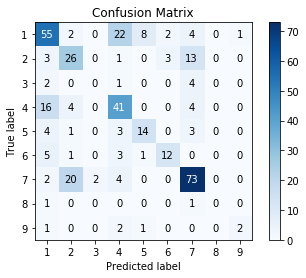

In [22]:
probas = model.predict([val_set_input_begin, val_set_input_end, val_set_input_gene, val_set_input_variation])
pred_indices = np.argmax(probas, axis=1)
classes = np.array(range(1, 10))
preds = classes[pred_indices]
print('Log loss: {}'.format(log_loss(classes[np.argmax(val_set_output, axis=1)], probas)))
print('Accuracy: {}'.format(accuracy_score(classes[np.argmax(val_set_output, axis=1)], preds)))
skplt.plot_confusion_matrix(classes[np.argmax(val_set_output, axis=1)], preds)


## Train with validation set

For the final submission we can add the validation set to the training set and run the network for 4 epochs. After 4 epcohs it starts overfitting in the validation set. We only do this to add more training samples and try to get better results this way

In [23]:
model.fit([
    np.concatenate([train_set_input_begin, val_set_input_begin]), 
    np.concatenate([train_set_input_end,val_set_input_end]), 
    np.concatenate([train_set_input_gene, val_set_input_gene]), 
    np.concatenate([train_set_input_variation, val_set_input_variation])
],  np.concatenate([train_set_output,val_set_output]), 
    epochs=4, batch_size=16, callbacks=[ckpt_callback])

Epoch 1/4
3689/3689 [==============================] - 2567s - loss: 0.7371  

/home/jorge/companies/chute/pythonenv/iris3/lib/python3.6/site-packages/keras/callbacks.py:405: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)



Epoch 2/4
3689/3689 [==============================] - 2568s - loss: 0.6288  
Epoch 3/4
3689/3689 [==============================] - 2557s - loss: 0.5720  
Epoch 4/4
3689/3689 [==============================] - 2572s - loss: 0.6104  


## Submission

In [17]:
probas = model.predict([test_set_input_begin, test_set_input_end, test_set_input_gene, test_set_input_variation])

In [18]:
submission_df = pd.DataFrame(probas, columns=['class'+str(c+1) for c in range(9)])
submission_df['ID'] = df_test['ID']
submission_df.head()

,class1,class2,class3,class4,class5,class6,class7,class8,class9,ID
0,0.238091,0.007231,0.004479,0.668008,0.032579,0.028462,0.020158,0.000361,0.000631,1
1,0.623407,0.036642,0.001584,0.183017,0.055994,0.072700,0.020672,0.002371,0.003614,2
2,0.007038,0.332710,0.001060,0.000995,0.008286,0.006846,0.642188,0.000697,0.000178,3
3,0.001037,0.420275,0.000757,0.000485,0.003372,0.002968,0.570505,0.000505,0.000096,4
4,0.034064,0.092081,0.001345,0.014544,0.012756,0.014006,0.828419,0.001950,0.000836,5


In [19]:
submission_df.to_csv('submission.csv', index=False)

# Public LB Score: 0.93662

The private leaderboard shows and score of 2.8. Everybody get much worse results in the private leader board, there has been a long discussion in the forums.